# Citations to *Gaia* release papers

As given by [ADS](https://ui.adsabs.harvard.edu/).

A similar code is run daily using GitHub actions here: https://github.com/TristanCantatGaudin/ADS-Gaia-Citations/

In [1]:
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

KEY = # insert your ADS API key here as a string

gaiaPapers = ['2016A&A...595A...1G',
              '2016A&A...595A...2G',
              '2018A&A...616A...1G',
              '2021A&A...649A...1G',
              '2023A&A...674A...1G']

Query the list of papers citing each one of the above papers, groupd them by month, and count.

The ADS API returns a maximum of 2000 items, so if the result contains exactly 2000 items it means we must query again specifying ``start=2000``, then possibly `start=4000` etc.

In [2]:
%%time
allDateBins = []
allCounts = []

for m in gaiaPapers:

	extractedInfo = []

	finished=False
	pageNb = 0

	#query ten times 2000
	while finished==False:
		print( 'Querying citation list for paper:',m)
		queryString = "curl -H 'Authorization: Bearer:"+KEY+"' 'https://api.adsabs.harvard.edu/v1/search/query?q=citations(bibcode%3A"+m.replace('&','%26')+")&fl=pubdate&rows=2000&start="+str(pageNb*2000)+"'"
		#print( queryString )
		rawResult =  subprocess.check_output(queryString, shell=True).decode('utf-8')
		#print( rawResult )

		ppp = json.loads(rawResult)
		newExtractedInfo = [paper['pubdate'].replace('-00','-01') for paper in ppp['response']['docs']]

		extractedInfo = extractedInfo + newExtractedInfo
		pageNb = pageNb + 1

		if len(newExtractedInfo)<2000:
			finished = True

	theseDates = pd.to_datetime( extractedInfo ) #convert from string to date
	df = pd.DataFrame(theseDates,columns =['date'])   #make it a pandas dataframe
	df.set_index('date', inplace=True) #now date is the index, and the column date is removed: the dataframe has no columns


	#this is the part that makes a histogram:
	counts = list( df.resample('M').size().tolist() ) # a list of integers
	dateBins = list(df.resample('M').size().index.values) #a list of numpy.datetime64 objects
	#pandas returns the END of the bin, so e.g. for August the bin is "August 31st"
	dateBins = [ np.datetime64( t[:-2]+'01' ) for t in [ np.datetime_as_string(t, unit='D') for t in dateBins ] ]
	# print( [ np.datetime_as_string(t, unit='D') for t in dateBins ] )
	#the previous line converts the time to string and back, so we get rid of the "time of the day" and move back to day 1.
	#	->	August31stT00:00:00 becomes August1st

	if len(counts)>0:

		allDateBins.append( np.array(dateBins) )
		allCounts.append( np.array(counts) )


allTimeBins = sorted(set(np.concatenate(allDateBins).ravel()))
print('All done.')

Querying citation list for paper: 2016A&A...595A...1G
Querying citation list for paper: 2016A&A...595A...1G
Querying citation list for paper: 2016A&A...595A...1G
Querying citation list for paper: 2016A&A...595A...2G
Querying citation list for paper: 2018A&A...616A...1G
Querying citation list for paper: 2018A&A...616A...1G
Querying citation list for paper: 2018A&A...616A...1G
Querying citation list for paper: 2018A&A...616A...1G
Querying citation list for paper: 2021A&A...649A...1G
Querying citation list for paper: 2021A&A...649A...1G
Querying citation list for paper: 2023A&A...674A...1G
All done.
CPU times: user 146 ms, sys: 96.7 ms, total: 243 ms
Wall time: 36.1 s


Cosmetics:

In [3]:
try:
    import mplcyberpunk
    plt.style.use('cyberpunk')
    #### Reset font because cyberpunk overrides it?
    from matplotlib import font_manager
    font_dirs = ['.']
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    # set font
    plt.rcParams['font.family'] = 'NotesEsa'
except:
    pass

Plot:

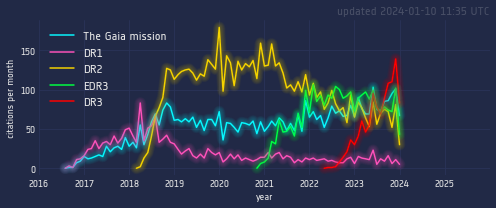

In [4]:
maxMonth = np.datetime64('now') #e.g. any date during Dec includes Dec and removes Jan
#maxMonth = np.datetime64('2022-02-17') #e.g. any date during Dec includes Dec and removes Jan
# NB here maxMonth is the month for which we end lines on the plot, not the limit of the x-axis.

allTimeBins = np.array( allTimeBins ) #so we can filter easily later

labels=['The Gaia mission','DR1','DR2','EDR3','DR3']

plt.figure(3,figsize=(7,3))
for i,c in enumerate(allCounts):
	newCount = np.array( [ allCounts[i][allDateBins[i] == XXX][0] if XXX in allDateBins[i] else 0 for XXX in allTimeBins ] )

	if i==2:
		minMonth = np.datetime64('2018-02-15T00:00')
		plt.plot( allTimeBins[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] ,
                 newCount[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] , label=labels[i] )


	elif i==3:
		minMonth = np.datetime64('2020-10-15T00:00')
		plt.plot( allTimeBins[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] ,
                 newCount[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] , label=labels[i] )

	elif i==0 or i==1:
		minMonth = np.datetime64('2016-07-15T00:00')
		plt.plot( allTimeBins[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] ,
                 newCount[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] , label=labels[i] )
		
	elif i==4:
		minMonth = np.datetime64('2022-04-15T00:00')
		plt.plot( allTimeBins[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] ,
                 newCount[(allTimeBins>minMonth)&(allTimeBins<maxMonth)] , label=labels[i] )


plt.xlabel('year')
plt.ylabel('citations per month')
plt.xlim( np.datetime64('2016-01-01T00:00') , np.datetime64('2025-12-30T23:59') )
plt.legend(loc='upper left',prop={'size': 12})
plt.title('updated %s UTC' % (np.datetime64('now').item().strftime("%Y-%m-%d %H:%M")) , loc='right' , alpha=0.2)

try:
    mplcyberpunk.make_lines_glow(n_glow_lines=10)
except:
    pass

plt.tight_layout()
plt.show()